<a href="https://colab.research.google.com/github/odartsi/Healthcare/blob/main/Parkinson_Predictions/Time_Series_Forecasting_Parkinson_Disease.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Import libraries

In [ ]:
import os
import datetime

import IPython
import IPython.display
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf

mpl.rcParams['figure.figsize'] = (8, 6)
mpl.rcParams['axes.grid'] = False

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Dataset

## Load data

In [ ]:
train_clinical_df=pd.read_csv('/content/drive/MyDrive/Colab Notebooks/amp-parkisons-disease-progression-predictions/train_clinical_data.csv')
train_peptides_df=pd.read_csv('/content/drive/MyDrive/Colab Notebooks/amp-parkisons-disease-progression-predictions/train_peptides.csv')
train_proteins_df=pd.read_csv('/content/drive/MyDrive/Colab Notebooks/amp-parkisons-disease-progression-predictions/train_proteins.csv')
sumplimental_clinical_df=pd.read_csv('/content/drive/MyDrive/Colab Notebooks/amp-parkisons-disease-progression-predictions/supplemental_clinical_data.csv')

In [ ]:
train_clinical_df.head()

,visit_id,patient_id,visit_month,updrs_1,updrs_2,updrs_3,updrs_4,upd23b_clinical_state_on_medication
0,55_0,55,0,10.0,6.0,15.0,NaN,NaN
1,55_3,55,3,10.0,7.0,25.0,NaN,NaN
2,55_6,55,6,8.0,10.0,34.0,NaN,NaN
3,55_9,55,9,8.0,9.0,30.0,0.0,On
4,55_12,55,12,10.0,10.0,41.0,0.0,On


In [ ]:
train_peptides_df.head()

,visit_id,visit_month,patient_id,UniProt,Peptide,PeptideAbundance
0,55_0,0,55,O00391,NEQEQPLGQWHLS,11254.3
1,55_0,0,55,O00533,GNPEPTFSWTK,102060.0
2,55_0,0,55,O00533,IEIPSSVQQVPTIIK,174185.0
3,55_0,0,55,O00533,KPQSAVYSTGSNGILLC(UniMod_4)EAEGEPQPTIK,27278.9
4,55_0,0,55,O00533,SMEQNGPGLEYR,30838.7


In [ ]:
train_proteins_df.head()

,visit_id,visit_month,patient_id,UniProt,NPX
0,55_0,0,55,O00391,11254.3
1,55_0,0,55,O00533,732430.0
2,55_0,0,55,O00584,39585.8
3,55_0,0,55,O14498,41526.9
4,55_0,0,55,O14773,31238.0


In [ ]:
sumplimental_clinical_df.head()

,visit_id,patient_id,visit_month,updrs_1,updrs_2,updrs_3,updrs_4,upd23b_clinical_state_on_medication
0,35_0,35,0,5.0,3.0,16.0,0.0,NaN
1,35_36,35,36,6.0,4.0,20.0,0.0,NaN
2,75_0,75,0,4.0,6.0,26.0,0.0,NaN
3,75_36,75,36,1.0,8.0,38.0,0.0,On
4,155_0,155,0,NaN,NaN,0.0,NaN,NaN


**train_clinical_data.csv**

- `visit_id` - ID code for the visit.
- `visit_month` - The month of the visit, relative to the first visit by the patient.
- `patient_id` - An ID code for the patient.
- `updrs_[1-4]` - The patient's score for part N of the Unified Parkinson's Disease Rating Scale. Higher numbers indicate more severe symptoms. Each sub-section covers a distinct category of symptoms, such as mood and behavior for Part 1 and motor functions for Part 3.
- `upd23b_clinical_state_on_medication` - Whether or not the patient was taking medication such as Levodopa during the UPDRS assessment. Expected to mainly affect the scores for Part 3 (motor function). These medications wear off fairly quickly (on the order of one day) so it's common for patients to take the motor function exam twice in a single month, both with and without medication.

**train_peptides.csv** Mass spectrometry data at the peptide level. Peptides are the component subunits of proteins.

- `visit_id` - ID code for the visit.
- `visit_month` - The month of the visit, relative to the first visit by the patient.
- `patient_id` - An ID code for the patient.
- `UniProt` - The UniProt ID code for the associated protein. There are often several peptides per protein.
- `Peptide` - The sequence of amino acids included in the peptide. See this table for the relevant codes. Some rare annotations may not be included in the table. The test set may include peptides not found in the train set.
- `PeptideAbundance` - The frequency of the amino acid in the sample.

**train_proteins.csv** Protein expression frequencies aggregated from the peptide level data.

- `visit_id` - ID code for the visit.
- `visit_month` - The month of the visit, relative to the first visit by the patient.
- `patient_id` - An ID code for the patient.
- `UniProt` - The UniProt ID code for the associated protein. There are often several peptides per protein. The test set may include proteins not found in the train set.
- `NPX` - Normalized protein expression. The frequency of the protein's occurrence in the sample. May not have a 1:1 relationship with the component peptides as some proteins contain repeated copies of a given peptide.

## Prepare dataset

We have to predict the ratings for the the first 4 segments of UPDRS updrs_1, updrs_2, updrs_3 and updrs_4 that is likely to be recorded by the clinic during a patient visit. Hence these are our labels.

We will now prepare the dataset for training models to predict the 4 labels.

To predict the target labels(updrs_1, updrs_2, updrs_3, updrs_4) for a given visit, we will use the recorded protein and peptide data of the patient during that visit.

First we will group the rows in train_proteins data by visit ids (visit id) and protein ids (UniProt). Then we will replace theNPX values of each row in a group with the mean of the NPX values of all rows in that group.

Similarly we will group the rows in train_peptides data by their visit ids(visit_id) and peptide ids(Peptide). Then we will replace the PeptideAbundance values of each row in a group with the mean of the PeptideAbundance values of all rows in that group.

The Protein dataset is pivoted such that unique values of visit_id become the indices and the values of UniProt1 in the dataset become columns. For each visit(row), the NPX values corresponding to the differentUniProt1 values recorded for that visit are captured in the columns.

The Peptipe dataset is pivoted such that unique values of visit_id become the indices and the values of Peptide in the dataset become columns. For each visit(row), the PeptideAbundance values corresponding to the differentPeptide values recorded for that visit are captured in the columns.

We will now merge the pivoted peptide dataset with the pivoted protein dataset on visit_id.


In [ ]:
# Function to prepare dataset with all the steps mentioned above:
def prepare_dataset(train_proteins, train_peptides):
    # Step 1: Grouping
    df_protein_grouped = train_proteins.groupby(['visit_id','UniProt'])['NPX'].mean().reset_index()
    df_peptide_grouped = train_peptides.groupby(['visit_id','Peptide'])['PeptideAbundance'].mean().reset_index()

    # Step 2: Pivoting
    df_protein = df_protein_grouped.pivot(index='visit_id',columns = 'UniProt', values = 'NPX').rename_axis(columns=None).reset_index()
    df_peptide = df_peptide_grouped.pivot(index='visit_id',columns = 'Peptide', values = 'PeptideAbundance').rename_axis(columns=None).reset_index()

    # Step 3: Merging
    pro_pep_df = df_protein.merge(df_peptide, on = ['visit_id'], how = 'left')
    dataset_df = pro_pep_df.merge(train_clinical_df[['visit_id', 'patient_id', 'visit_month', 'updrs_1', 'updrs_2', 'updrs_3', 'updrs_4']], on = ['visit_id'], how = 'left')


    return dataset_df

In [ ]:
dataset_df = prepare_dataset(train_proteins_df, train_peptides_df)

In [ ]:
dataset_df.head()

,visit_id,O00391,O00533,O00584,O14498,O14773,O14791,O15240,O15394,O43505,...,YWGVASFLQK,YYC(UniMod_4)FQGNQFLR,YYTYLIMNK,YYWGGQYTWDMAK,patient_id,visit_month,updrs_1,updrs_2,updrs_3,updrs_4
0,10053_0,9104.27,402321.0,NaN,NaN,7150.57,2497.84,83002.9,15113.6,167327.0,...,104260.0,530223.0,NaN,7207.30,10053.0,0.0,3.0,0.0,13.0,0.0
1,10053_12,10464.20,435586.0,NaN,NaN,NaN,NaN,197117.0,15099.1,164268.0,...,123254.0,453883.0,49281.9,25332.80,10053.0,12.0,4.0,2.0,8.0,0.0
2,10053_18,13235.70,507386.0,7126.96,24525.7,NaN,2372.71,126506.0,16289.6,168107.0,...,128336.0,447505.0,52389.1,21235.70,10053.0,18.0,2.0,2.0,0.0,0.0
3,10138_12,12600.20,494581.0,9165.06,27193.5,22506.10,6015.90,156313.0,54546.4,204013.0,...,129964.0,552232.0,65657.8,9876.98,10138.0,12.0,3.0,6.0,31.0,0.0
4,10138_24,12003.20,522138.0,4498.51,17189.8,29112.40,2665.15,151169.0,52338.1,240892.0,...,111799.0,NaN,56977.6,4903.09,10138.0,24.0,4.0,7.0,19.0,10.0


## Inspect and cleanup

In [ ]:
dataset_df.describe()

,O00391,O00533,O00584,O14498,O14773,O14791,O15240,O15394,O43505,O60888,...,YWGVASFLQK,YYC(UniMod_4)FQGNQFLR,YYTYLIMNK,YYWGGQYTWDMAK,patient_id,visit_month,updrs_1,updrs_2,updrs_3,updrs_4
count,764.000000,1.112000e+03,1100.000000,1032.000000,1047.000000,942.000000,1113.000000,1050.000000,1110.000000,1079.000000,...,1089.000000,1105.000000,1030.000000,865.00000,1068.000000,1068.000000,1068.000000,1068.000000,1058.000000,569.000000
mean,11641.264435,5.111649e+05,26505.529157,27305.934884,17688.295406,3004.990691,126151.780054,50773.474638,195599.363694,145382.047368,...,125937.993436,471554.596652,47068.709311,21072.04823,32673.328652,26.744382,6.566479,5.821161,17.300567,1.908612
std,2817.003530,2.357357e+05,10705.152540,8446.187506,7166.325369,1142.159575,72748.393517,21382.028764,79739.704279,58028.089713,...,38696.448657,131150.715245,13689.667117,10360.59380,18612.372744,22.839426,5.330702,5.931414,15.016371,3.077419
min,873.778000,5.971820e+04,591.103000,8945.340000,2811.120000,336.517000,10717.400000,5806.840000,29740.900000,8358.080000,...,991.452000,11371.200000,6362.490000,868.90300,55.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,9736.857500,3.490590e+05,19941.075000,21123.650000,12920.050000,2189.087500,70560.600000,37008.975000,142054.500000,103983.000000,...,100691.000000,384902.000000,37752.375000,14249.90000,16574.000000,6.000000,2.000000,1.000000,2.000000,0.000000
50%,11546.400000,4.834425e+05,26529.700000,26624.000000,17399.600000,2865.460000,116900.000000,50375.800000,185616.000000,136452.000000,...,123588.000000,463382.000000,45503.150000,20390.90000,29365.000000,24.000000,5.000000,4.000000,16.000000,0.000000
75%,13383.025000,6.485572e+05,33222.800000,32459.275000,22077.050000,3593.147500,164947.000000,63446.700000,239731.500000,177451.000000,...,149597.000000,549455.000000,54748.350000,27031.90000,50611.000000,48.000000,9.000000,9.000000,28.000000,3.000000
max,21361.800000,1.806980e+06,66252.400000,65347.900000,49695.600000,9352.640000,538862.000000,137369.000000,766591.000000,427084.000000,...,264224.000000,948416.000000,107220.000000,70020.80000,65043.000000,108.000000,33.000000,29.000000,78.000000,20.000000


In [ ]:
dataset_df.columns[dataset_df.isna().any()].tolist()

['O00391',
 'O00533',
 'O00584',
 'O14498',
 'O14773',
 'O14791',
 'O15394',
 'O43505',
 'O60888',
 'O75144',
 'O75326',
 'O94919',
 'P00441',
 'P00450',
 'P00734',
 'P00736',
 'P00738',
 'P00746',
 'P00747',
 'P00748',
 'P00751',
 'P01008',
 'P01019',
 'P01031',
 'P01033',
 'P01034',
 'P01344',
 'P01591',
 'P01594',
 'P01608',
 'P01621',
 'P01717',
 'P01780',
 'P01833',
 'P01857',
 'P01859',
 'P01860',
 'P01861',
 'P01877',
 'P02452',
 'P02652',
 'P02655',
 'P02656',
 'P02671',
 'P02675',
 'P02679',
 'P02747',
 'P02748',
 'P02750',
 'P02753',
 'P02760',
 'P02763',
 'P02792',
 'P04004',
 'P04075',
 'P04156',
 'P04180',
 'P04196',
 'P04207',
 'P04211',
 'P04216',
 'P04217',
 'P04275',
 'P04406',
 'P04433',
 'P05060',
 'P05067',
 'P05155',
 'P05156',
 'P05408',
 'P05452',
 'P05546',
 'P06310',
 'P06454',
 'P06681',
 'P06727',
 'P07195',
 'P07225',
 'P07333',
 'P07339',
 'P07711',
 'P07858',
 'P07998',
 'P08123',
 'P08133',
 'P08253',
 'P08294',
 'P08493',
 'P08571',
 'P08603',
 'P08637',

We can see that there are a lot of NaN values in the peptides and proteines, which affect a lot the predictions. We have to deal with those NaN values, but removing them all together will result on loosing a lot of data points.

If we instead impute them with any of the well known methods: knn, mean, median etc we will probably risk to bias the sample and the correlations between thoses proteins and the uprs levels we want to predict, will not be accurate.

Instead, I implemented a method that does the following:
- for each nan value we check if for the given row the column(protein type) that is most correlated  to it has a non Nan value, if yes we calclate the missing value based on the correlation function. If the most correlated column has also missing value we would calculate the value based on the 2nd most correlated column.

## Correlations before imputations

<ipython-input-23-8a7a0431d523>:2: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  sns.heatmap(dataset_df.iloc[:,:20].corr(), annot=True);


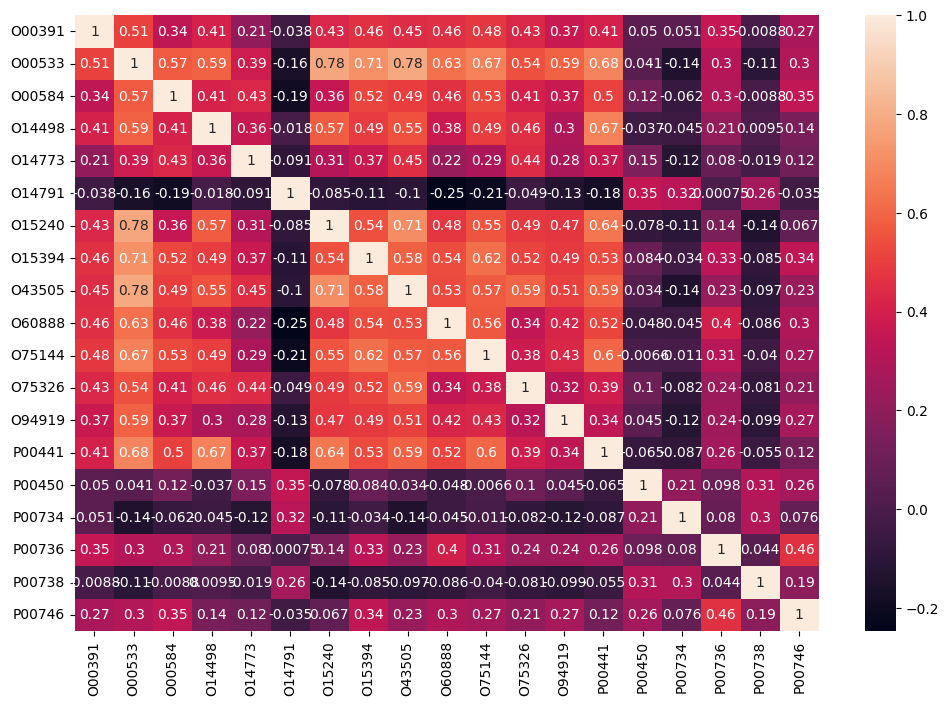

In [ ]:
plt.figure(figsize=(12,8))
sns.heatmap(dataset_df.iloc[:,:20].corr(), annot=True);

In [ ]:
dataset_df.head()

,visit_id,O00391,O00533,O00584,O14498,O14773,O14791,O15240,O15394,O43505,...,YWGVASFLQK,YYC(UniMod_4)FQGNQFLR,YYTYLIMNK,YYWGGQYTWDMAK,patient_id,visit_month,updrs_1,updrs_2,updrs_3,updrs_4
0,10053_0,9104.27,402321.0,NaN,NaN,7150.57,2497.84,83002.9,15113.6,167327.0,...,104260.0,530223.0,NaN,7207.30,10053.0,0.0,3.0,0.0,13.0,0.0
1,10053_12,10464.20,435586.0,NaN,NaN,NaN,NaN,197117.0,15099.1,164268.0,...,123254.0,453883.0,49281.9,25332.80,10053.0,12.0,4.0,2.0,8.0,0.0
2,10053_18,13235.70,507386.0,7126.96,24525.7,NaN,2372.71,126506.0,16289.6,168107.0,...,128336.0,447505.0,52389.1,21235.70,10053.0,18.0,2.0,2.0,0.0,0.0
3,10138_12,12600.20,494581.0,9165.06,27193.5,22506.10,6015.90,156313.0,54546.4,204013.0,...,129964.0,552232.0,65657.8,9876.98,10138.0,12.0,3.0,6.0,31.0,0.0
4,10138_24,12003.20,522138.0,4498.51,17189.8,29112.40,2665.15,151169.0,52338.1,240892.0,...,111799.0,NaN,56977.6,4903.09,10138.0,24.0,4.0,7.0,19.0,10.0


In [ ]:
# Checking which column has the highest correlation with which column
df=dataset_df.iloc[:,1:20]
correlations = df.corr()  # Compute the correlation matrix

# Iterate over each column in the DataFrame
for column in df.columns:
    # Find the column with the highest correlation (excluding self-correlation)
    max_corr_col = correlations[column].drop(column).idxmax()

    # Get the value of the highest correlation
    max_corr_value = correlations[column][max_corr_col]

    # Print the results
    print(f"The column '{column}' has the highest correlation with '{max_corr_col}' (correlation value: {max_corr_value})")

The column 'O00391' has the highest correlation with 'O00533' (correlation value: 0.510919080552256)
The column 'O00533' has the highest correlation with 'O43505' (correlation value: 0.7849402791118381)
The column 'O00584' has the highest correlation with 'O00533' (correlation value: 0.5679357019493568)
The column 'O14498' has the highest correlation with 'P00441' (correlation value: 0.6691661844632155)
The column 'O14773' has the highest correlation with 'O43505' (correlation value: 0.45198964665230107)
The column 'O14791' has the highest correlation with 'P00450' (correlation value: 0.3474927131312026)
The column 'O15240' has the highest correlation with 'O00533' (correlation value: 0.7804008984417943)
The column 'O15394' has the highest correlation with 'O00533' (correlation value: 0.7147670984114167)
The column 'O43505' has the highest correlation with 'O00533' (correlation value: 0.7849402791118381)
The column 'O60888' has the highest correlation with 'O00533' (correlation value: 

In [ ]:
correlations = dataset_df.corr()  # Compute the correlation matrix

# Define a function to replace missing values with calculated values based on correlation
# def replace_missing_values(df,row):
#     for column in df.columns:
#         if pd.isnull(row[column]):  # Check if the value is NaN
#             max_corr_col = correlations[column].drop(column).idxmax()
#             second_max_corr_col = correlations[column].drop([column, max_corr_col]).idxmax()

#             if pd.isnull(row[max_corr_col]):  # Check if the most correlated column is also NaN
#                 X = row[second_max_corr_col]  # Known value (X)
#                 correlation = correlations[column][second_max_corr_col]  # Correlation coefficient
#                 mean_X = df[second_max_corr_col].mean()  # Mean of the most correlated column
#                 mean_Y = df[column].mean()
#                 std_X = df[second_max_corr_col].std()
#                 std_Y = df[column].std()
#                 Y = mean_Y + correlation * (std_Y / std_X) * (X - mean_X)
#                 row[column] = row[second_max_corr_col]
#             else:
#                 X = row[max_corr_col]  # Known value (X)
#                 correlation = correlations[column][max_corr_col]  # Correlation coefficient
#                 mean_X = df[max_corr_col].mean()  # Mean of the most correlated column
#                 mean_Y = df[column].mean()
#                 std_X = df[max_corr_col].std()
#                 std_Y = df[column].std()
#                 Y = mean_Y + correlation * (std_Y / std_X) * (X - mean_X)
#             row[column] = Y
#     return row

def replace_missing_values(df, row):
    for column in df.columns:
        if pd.isnull(row[column]):  # Check if the value is NaN
            # Sort columns by correlation in descending order
            sorted_columns = correlations[column].drop(column).sort_values(ascending=False).index

            # Find the first column with a non-NaN value
            for col in sorted_columns:
                if not pd.isnull(row[col]):
                    X = row[col]  # Known value (X)
                    correlation = correlations[column][col]  # Correlation coefficient
                    mean_X = df[col].mean()  # Mean of the most correlated column
                    mean_Y = df[column].mean()
                    std_X = df[col].std()
                    std_Y = df[column].std()
                    Y = mean_Y + correlation * (std_Y / std_X) * (X - mean_X)
                    row[column] = Y
                    break  # Stop after finding the first non-NaN value
    return row

# Updating each missing value per raw of the dataframe
for row_index in range(len(dataset_df)):
  row = dataset_df.loc[row_index]
  #updated_row = replace_missing_values(dataset_df,row)

  # Update the original DataFrame with the updated row
  dataset_df.loc[row_index] = replace_missing_values(dataset_df,row)#updated_row

Streaming output truncated to the last 5000 lines.
<ipython-input-26-2a2397115c64>:46: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  row[column] = Y
<ipython-input-26-2a2397115c64>:46: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  row[column] = Y
<ipython-input-26-2a2397115c64>:46: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  row[column] = Y
<ipython-input-26-2a2397115c64>:46: SettingWithCopyWarning: 
A value is trying to be set on a 

In [ ]:
dataset_df

,visit_id,O00391,O00533,O00584,O14498,O14773,O14791,O15240,O15394,O43505,...,YWGVASFLQK,YYC(UniMod_4)FQGNQFLR,YYTYLIMNK,YYWGGQYTWDMAK,patient_id,visit_month,updrs_1,updrs_2,updrs_3,updrs_4
0,10053_0,9104.270000,402321.0,14662.944006,26607.502496,7150.570000,2497.840000,83002.9,15113.6,167327.0,...,104260.0,530223.000000,39847.604093,7207.300000,10053.0,0.0,3.0,0.0,13.0,0.000000
1,10053_12,10464.200000,435586.0,13687.726827,28021.712611,14796.647768,3760.839065,197117.0,15099.1,164268.0,...,123254.0,453883.000000,49281.900000,25332.800000,10053.0,12.0,4.0,2.0,8.0,0.000000
2,10053_18,13235.700000,507386.0,7126.960000,24525.700000,15362.624531,2372.710000,126506.0,16289.6,168107.0,...,128336.0,447505.000000,52389.100000,21235.700000,10053.0,18.0,2.0,2.0,0.0,0.000000
3,10138_12,12600.200000,494581.0,9165.060000,27193.500000,22506.100000,6015.900000,156313.0,54546.4,204013.0,...,129964.0,552232.000000,65657.800000,9876.980000,10138.0,12.0,3.0,6.0,31.0,0.000000
4,10138_24,12003.200000,522138.0,4498.510000,17189.800000,29112.400000,2665.150000,151169.0,52338.1,240892.0,...,111799.0,523674.117378,56977.600000,4903.090000,10138.0,24.0,4.0,7.0,19.0,10.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1108,8699_24,9983.000000,400290.0,24240.100000,23098.034406,16943.500000,6303.170000,77493.6,46435.3,254247.0,...,133682.0,571879.000000,80268.300000,54889.700000,8699.0,24.0,11.0,10.0,13.0,2.000000
1109,942_12,6757.320000,360858.0,18367.600000,14760.700000,18603.400000,1722.770000,86847.4,37741.3,212132.0,...,77976.8,486239.000000,45032.700000,14169.375291,942.0,12.0,5.0,2.0,25.0,0.000000
1110,942_24,10370.960927,352722.0,22834.900000,23393.100000,16693.500000,1487.910000,114772.0,36095.7,185836.0,...,74483.1,561398.000000,52916.400000,21847.600000,942.0,24.0,2.0,3.0,23.0,0.748599
1111,942_48,11627.800000,251820.0,22046.500000,26360.500000,22440.200000,2117.430000,82241.9,30146.6,167633.0,...,64601.8,632782.000000,51123.700000,20700.300000,942.0,48.0,2.0,6.0,35.0,0.000000


In [ ]:
# Calculate the total number of values in the dataframe
total_values = dataset_df.size

# Calculate the number of NaN values in the dataframe
nan_values = dataset_df.isna().sum().sum()

# Calculate the percentage of NaN values
percentage_nan = (nan_values / total_values) * 100

print(f"The percentage of NaN values in the dataframe is: {percentage_nan:.2f}%")


The percentage of NaN values in the dataframe is: 0.00%


In [ ]:
dataset_df

,visit_id,O00391,O00533,O00584,O14498,O14773,O14791,O15240,O15394,O43505,...,YWGVASFLQK,YYC(UniMod_4)FQGNQFLR,YYTYLIMNK,YYWGGQYTWDMAK,patient_id,visit_month,updrs_1,updrs_2,updrs_3,updrs_4
0,10053_0,9104.270000,402321.0,14662.944006,26607.502496,7150.570000,2497.840000,83002.9,15113.6,167327.0,...,104260.0,530223.000000,39847.604093,7207.300000,10053.0,0.0,3.0,0.0,13.0,0.000000
1,10053_12,10464.200000,435586.0,13687.726827,28021.712611,14796.647768,3760.839065,197117.0,15099.1,164268.0,...,123254.0,453883.000000,49281.900000,25332.800000,10053.0,12.0,4.0,2.0,8.0,0.000000
2,10053_18,13235.700000,507386.0,7126.960000,24525.700000,15362.624531,2372.710000,126506.0,16289.6,168107.0,...,128336.0,447505.000000,52389.100000,21235.700000,10053.0,18.0,2.0,2.0,0.0,0.000000
3,10138_12,12600.200000,494581.0,9165.060000,27193.500000,22506.100000,6015.900000,156313.0,54546.4,204013.0,...,129964.0,552232.000000,65657.800000,9876.980000,10138.0,12.0,3.0,6.0,31.0,0.000000
4,10138_24,12003.200000,522138.0,4498.510000,17189.800000,29112.400000,2665.150000,151169.0,52338.1,240892.0,...,111799.0,523674.117378,56977.600000,4903.090000,10138.0,24.0,4.0,7.0,19.0,10.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1108,8699_24,9983.000000,400290.0,24240.100000,23098.034406,16943.500000,6303.170000,77493.6,46435.3,254247.0,...,133682.0,571879.000000,80268.300000,54889.700000,8699.0,24.0,11.0,10.0,13.0,2.000000
1109,942_12,6757.320000,360858.0,18367.600000,14760.700000,18603.400000,1722.770000,86847.4,37741.3,212132.0,...,77976.8,486239.000000,45032.700000,14169.375291,942.0,12.0,5.0,2.0,25.0,0.000000
1110,942_24,10370.960927,352722.0,22834.900000,23393.100000,16693.500000,1487.910000,114772.0,36095.7,185836.0,...,74483.1,561398.000000,52916.400000,21847.600000,942.0,24.0,2.0,3.0,23.0,0.748599
1111,942_48,11627.800000,251820.0,22046.500000,26360.500000,22440.200000,2117.430000,82241.9,30146.6,167633.0,...,64601.8,632782.000000,51123.700000,20700.300000,942.0,48.0,2.0,6.0,35.0,0.000000


<ipython-input-41-8a7a0431d523>:2: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  sns.heatmap(dataset_df.iloc[:,:20].corr(), annot=True);


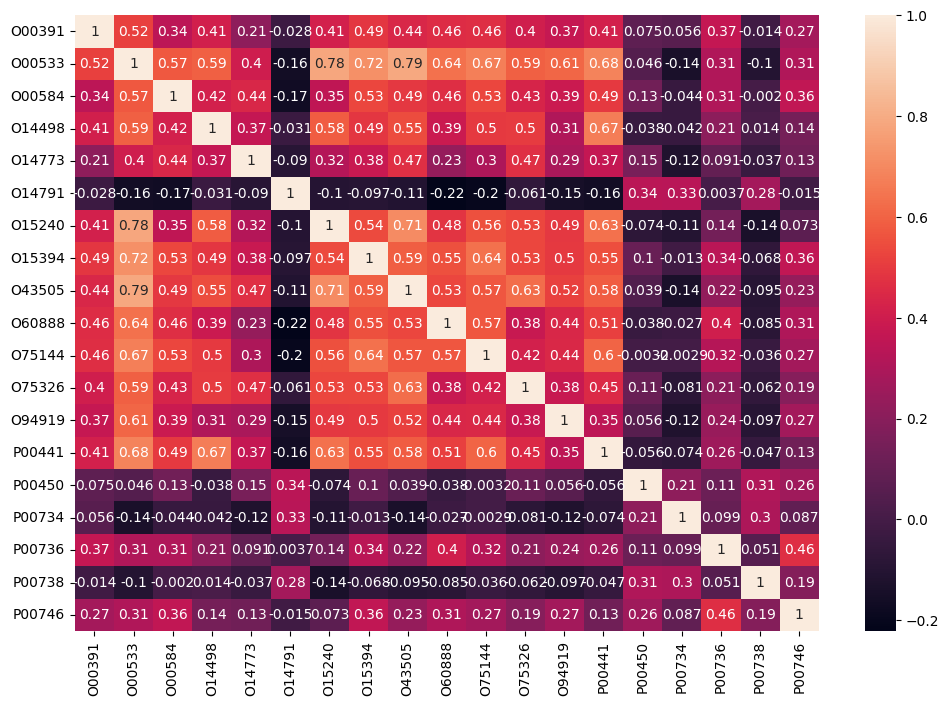

In [ ]:
plt.figure(figsize=(12,8))
sns.heatmap(dataset_df.iloc[:,:20].corr(), annot=True);

### Split the data
You'll use a (70%, 20%, 10%) split for the training, validation, and test sets. Note the data is not being randomly shuffled before splitting. This is for two reasons:

It ensures that chopping the data into windows of consecutive samples is still possible.
It ensures that the validation/test results are more realistic, being evaluated on the data collected after the model was trained.

In [ ]:
def split_dataset(df):
  #column_indices = {name: i for i, name in enumerate(dataset_df.columns)}

  n = len(df)
  train_df = df[0:int(n*0.7)]
  val_df = df[int(n*0.7):int(n*0.9)]
  test_df = df[int(n*0.9):]

  num_features =df.shape[1]
  return train_df, val_df, test_df

### Normalize the data

It is important to scale features before training a neural network. Normalization is a common way of doing this scaling: subtract the mean and divide by the standard deviation of each feature.

The mean and standard deviation should only be computed using the training data so that the models have no access to the values in the validation and test sets.

It's also arguable that the model shouldn't have access to future values in the training set when training, and that this normalization should be done using moving averages. That's not the focus of this tutorial, and the validation and test sets ensure that you get (somewhat) honest metrics. So, in the interest of simplicity this tutorial uses a simple average.

In [ ]:
def normalize_datset(train_df, val_df, test_df):
    # train_df=train_df.drop('visit_id', axis=1)
    # test_df=test_df.drop('visit_id', axis=1)
    # val_df=val_df.drop('visit_id', axis=1)

    train_mean = train_df.mean()
    train_std = train_df.std()

    train_df = (train_df - train_mean) / train_std
    val_df = (val_df - train_mean) / train_std
    test_df = (test_df - train_mean) / train_std

    return train_df, val_df, test_df

In [ ]:
train_df.head()

,O00391,O00533,O00584,O14498,O14773,O14791,O15240,O15394,O43505,O60888,...,YWGVASFLQK,YYC(UniMod_4)FQGNQFLR,YYTYLIMNK,YYWGGQYTWDMAK,patient_id,visit_month,updrs_1,updrs_2,updrs_3,updrs_4
0,-0.937961,-0.494900,-1.078117,-0.073171,-1.498616,-0.388367,-0.591076,-1.688796,-0.366147,-0.322538,...,-0.533213,0.451007,-0.526915,-1.315989,-1.324237,-1.208017,-0.665276,-0.973506,-0.274393,-0.694672
1,-0.392921,-0.356370,-1.168273,0.095091,-0.354947,0.768719,0.976894,-1.689494,-0.405142,-0.680330,...,-0.054396,-0.139100,0.171032,0.516346,-1.324237,-0.656888,-0.475906,-0.630432,-0.620621,-0.694672
2,0.717856,-0.057365,-1.774802,-0.320862,-0.270290,-0.503004,0.006673,-1.632232,-0.356204,0.271014,...,0.073715,-0.188402,0.400902,0.102164,-1.324237,-0.381324,-0.854646,-0.630432,-1.174585,-0.694672
3,0.463157,-0.110690,-1.586384,-0.003449,0.798202,2.834676,0.416232,0.207888,0.101507,-1.558641,...,0.114755,0.621137,1.382518,-1.046107,-1.317606,-0.656888,-0.665276,0.055718,0.972027,-0.694672
4,0.223888,0.004069,-2.017796,-1.193683,1.786345,-0.235088,0.345551,0.101670,0.571622,-1.062270,...,-0.343164,0.400385,0.740359,-1.548925,-1.317606,-0.105760,-0.475906,0.227255,0.141080,3.428787


##  Data Windowing

In [ ]:
dataset_df.head()

,visit_id,O00391,O00533,O00584,O14498,O14773,O14791,O15240,O15394,O43505,...,YWGVASFLQK,YYC(UniMod_4)FQGNQFLR,YYTYLIMNK,YYWGGQYTWDMAK,patient_id,visit_month,updrs_1,updrs_2,updrs_3,updrs_4
0,10053_0,9104.27,402321.0,14662.944006,26607.502496,7150.570000,2497.840000,83002.9,15113.6,167327.0,...,104260.0,530223.000000,39847.604093,7207.30,10053.0,0.0,3.0,0.0,13.0,0.0
1,10053_12,10464.20,435586.0,13687.726827,28021.712611,14796.647768,3760.839065,197117.0,15099.1,164268.0,...,123254.0,453883.000000,49281.900000,25332.80,10053.0,12.0,4.0,2.0,8.0,0.0
2,10053_18,13235.70,507386.0,7126.960000,24525.700000,15362.624531,2372.710000,126506.0,16289.6,168107.0,...,128336.0,447505.000000,52389.100000,21235.70,10053.0,18.0,2.0,2.0,0.0,0.0
3,10138_12,12600.20,494581.0,9165.060000,27193.500000,22506.100000,6015.900000,156313.0,54546.4,204013.0,...,129964.0,552232.000000,65657.800000,9876.98,10138.0,12.0,3.0,6.0,31.0,0.0
4,10138_24,12003.20,522138.0,4498.510000,17189.800000,29112.400000,2665.150000,151169.0,52338.1,240892.0,...,111799.0,523674.117378,56977.600000,4903.09,10138.0,24.0,4.0,7.0,19.0,10.0


In [ ]:
dataset_df.loc[dataset_df.patient_id==dataset_df.patient_id[0]]

,visit_id,O00391,O00533,O00584,O14498,O14773,O14791,O15240,O15394,O43505,...,YWGVASFLQK,YYC(UniMod_4)FQGNQFLR,YYTYLIMNK,YYWGGQYTWDMAK,patient_id,visit_month,updrs_1,updrs_2,updrs_3,updrs_4
0,10053_0,9104.27,402321.0,14662.944006,26607.502496,7150.570000,2497.840000,83002.9,15113.6,167327.0,...,104260.0,530223.0,39847.604093,7207.3,10053.0,0.0,3.0,0.0,13.0,0.0
1,10053_12,10464.20,435586.0,13687.726827,28021.712611,14796.647768,3760.839065,197117.0,15099.1,164268.0,...,123254.0,453883.0,49281.900000,25332.8,10053.0,12.0,4.0,2.0,8.0,0.0
2,10053_18,13235.70,507386.0,7126.960000,24525.700000,15362.624531,2372.710000,126506.0,16289.6,168107.0,...,128336.0,447505.0,52389.100000,21235.7,10053.0,18.0,2.0,2.0,0.0,0.0


In [ ]:
FEATURES = [i for i in dataset_df.columns if i not in ["visit_id"]]
FEATURES.append("visit_month")


In [ ]:
class WindowGenerator():
  def __init__(self, input_width, label_width, shift,
               train_df=train_df, val_df=val_df, test_df=test_df,
               label_columns=None):
    # Store the raw data.
    self.train_df = train_df
    self.val_df = val_df
    self.test_df = test_df

    # Work out the label column indices.
    self.label_columns = label_columns
    if label_columns is not None:
      self.label_columns_indices = {name: i for i, name in
                                    enumerate(label_columns)}
    self.column_indices = {name: i for i, name in
                           enumerate(train_df.columns)}

    # Work out the window parameters.
    self.input_width = input_width
    self.label_width = label_width
    self.shift = shift

    self.total_window_size = input_width + shift

    self.input_slice = slice(0, input_width)
    self.input_indices = np.arange(self.total_window_size)[self.input_slice]

    self.label_start = self.total_window_size - self.label_width
    self.labels_slice = slice(self.label_start, None)
    self.label_indices = np.arange(self.total_window_size)[self.labels_slice]

  def __repr__(self):
    return '\n'.join([
        f'Total window size: {self.total_window_size}',
        f'Input indices: {self.input_indices}',
        f'Label indices: {self.label_indices}',
        f'Label column name(s): {self.label_columns}'])

In [ ]:
w1 = WindowGenerator(input_width=24, label_width=1, shift=24,
                     label_columns=['updrs_4'])
w1

Total window size: 48
Input indices: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23]
Label indices: [47]
Label column name(s): ['updrs_4']

In [ ]:
w2 = WindowGenerator(input_width=6, label_width=1, shift=1,
                     label_columns=['updrs_4'])
w2

Total window size: 7
Input indices: [0 1 2 3 4 5]
Label indices: [6]
Label column name(s): ['updrs_4']

In [ ]:
def split_window(self, features):
  inputs = features[:, self.input_slice, :]
  labels = features[:, self.labels_slice, :]
  if self.label_columns is not None:
    labels = tf.stack(
        [labels[:, :, self.column_indices[name]] for name in self.label_columns],
        axis=-1)

  # Slicing doesn't preserve static shape information, so set the shapes
  # manually. This way the `tf.data.Datasets` are easier to inspect.
  inputs.set_shape([None, self.input_width, None])
  labels.set_shape([None, self.label_width, None])

  return inputs, labels

WindowGenerator.split_window = split_window

In [ ]:
# Stack three slices, the length of the total window.
example_window = tf.stack([np.array(train_df[:w2.total_window_size]),
                           np.array(train_df[100:100+w2.total_window_size]),
                           np.array(train_df[200:200+w2.total_window_size])])

example_inputs, example_labels = w2.split_window(example_window)

print('All shapes are: (batch, time, features)')
print(f'Window shape: {example_window.shape}')
print(f'Inputs shape: {example_inputs.shape}')
print(f'Labels shape: {example_labels.shape}')

All shapes are: (batch, time, features)
Window shape: (3, 7, 1203)
Inputs shape: (3, 6, 1203)
Labels shape: (3, 1, 1)


In [ ]:
def plot(self, model=None, plot_col='updrs_4', max_subplots=3):
  inputs, labels = self.example
  plt.figure(figsize=(12, 8))
  plot_col_index = self.column_indices[plot_col]
  max_n = min(max_subplots, len(inputs))
  for n in range(max_n):
    plt.subplot(max_n, 1, n+1)
    plt.ylabel(f'{plot_col} [normed]')
    plt.plot(self.input_indices, inputs[n, :, plot_col_index],
             label='Inputs', marker='.', zorder=-10)

    if self.label_columns:
      label_col_index = self.label_columns_indices.get(plot_col, None)
    else:
      label_col_index = plot_col_index

    if label_col_index is None:
      continue

    plt.scatter(self.label_indices, labels[n, :, label_col_index],
                edgecolors='k', label='Labels', c='#2ca02c', s=64)
    if model is not None:
      predictions = model(inputs)
      plt.scatter(self.label_indices, predictions[n, :, label_col_index],
                  marker='X', edgecolors='k', label='Predictions',
                  c='#ff7f0e', s=64)

    if n == 0:
      plt.legend()

  plt.xlabel('Time [h]')

WindowGenerator.plot = plot

In [ ]:
def make_dataset(self, data):
  data = np.array(data, dtype=np.float32)
  ds = tf.keras.utils.timeseries_dataset_from_array(
      data=data,
      targets=None,
      sequence_length=self.total_window_size,
      sequence_stride=1,
      shuffle=True,
      batch_size=32,)

  ds = ds.map(self.split_window)

  return ds

WindowGenerator.make_dataset = make_dataset

In [ ]:
@property
def train(self):
  return self.make_dataset(self.train_df)

@property
def val(self):
  return self.make_dataset(self.val_df)

@property
def test(self):
  return self.make_dataset(self.test_df)

@property
def example(self):
  """Get and cache an example batch of `inputs, labels` for plotting."""
  result = getattr(self, '_example', None)
  if result is None:
    # No example batch was found, so get one from the `.train` dataset
    result = next(iter(self.train))
    # And cache it for next time
    self._example = result
  return result

WindowGenerator.train = train
WindowGenerator.val = val
WindowGenerator.test = test
WindowGenerator.example = example

In [ ]:
single_step_window = WindowGenerator(
    input_width=1, label_width=1, shift=1,
    label_columns=['updrs_4'])
single_step_window

Total window size: 2
Input indices: [0]
Label indices: [1]
Label column name(s): ['updrs_4']

In [ ]:
class Baseline(tf.keras.Model):
  def __init__(self, label_index=None):
    super().__init__()
    self.label_index = label_index

  def call(self, inputs):
    if self.label_index is None:
      return inputs
    result = inputs[:, :, self.label_index]
    return result[:, :, tf.newaxis]

In [ ]:
baseline = Baseline(label_index=column_indices['updrs_4'])

baseline.compile(loss=tf.keras.losses.MeanSquaredError(),
                 metrics=[tf.keras.metrics.MeanAbsoluteError()])

val_performance = {}
performance = {}
val_performance['Baseline'] = baseline.evaluate(single_step_window.val)
performance['Baseline'] = baseline.evaluate(single_step_window.test, verbose=0)

7/7 [==============================] - 0s 3ms/step - loss: 1.8064 - mean_absolute_error: 1.0101


In [ ]:
wide_window = WindowGenerator(
    input_width=24, label_width=24, shift=1,
    label_columns=['updrs_4'])

wide_window

Total window size: 25
Input indices: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23]
Label indices: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24]
Label column name(s): ['updrs_4']

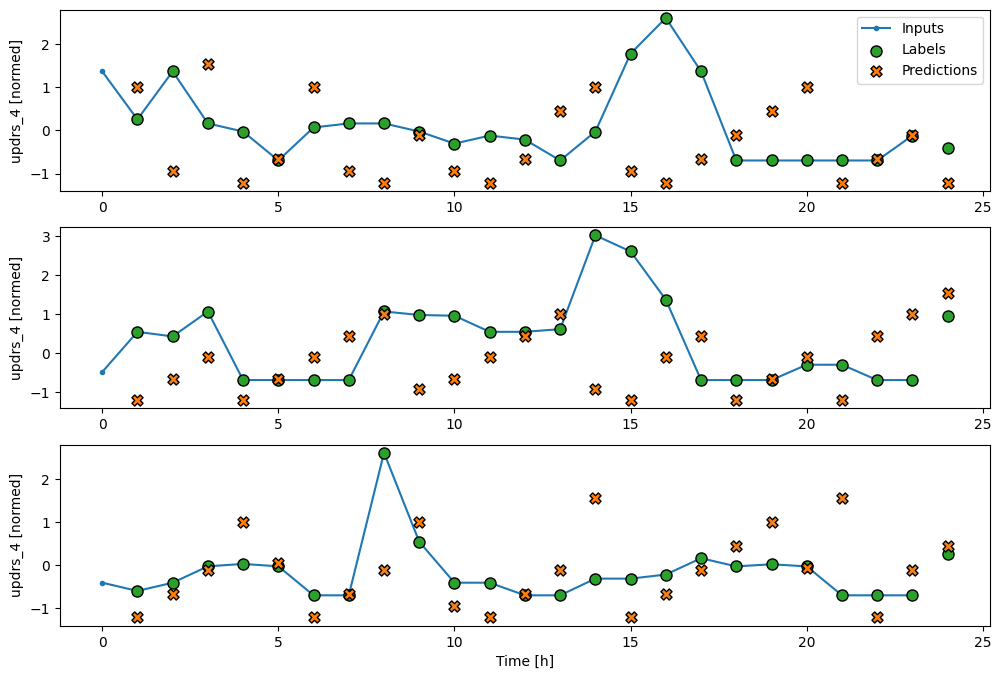

In [ ]:
wide_window.plot(baseline)

In [ ]:
linear = tf.keras.Sequential([
    tf.keras.layers.Dense(units=1)
])

In [ ]:
MAX_EPOCHS = 20

def compile_and_fit(model, window, patience=2):
  early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss',
                                                    patience=patience,
                                                    mode='min')

  model.compile(loss=tf.keras.losses.MeanSquaredError(),
                optimizer=tf.keras.optimizers.Adam(),
                metrics=[tf.keras.metrics.MeanAbsoluteError()])

  history = model.fit(window.train, epochs=MAX_EPOCHS,
                      validation_data=window.val,
                      callbacks=[early_stopping])
  return history

In [ ]:
history = compile_and_fit(linear, single_step_window)

val_performance['Linear'] = linear.evaluate(single_step_window.val)
performance['Linear'] = linear.evaluate(single_step_window.test, verbose=0)

Epoch 1/20
25/25 [==============================] - 1s 13ms/step - loss: 2.1376 - mean_absolute_error: 1.1131 - val_loss: 1.5765 - val_mean_absolute_error: 0.9672
Epoch 2/20
25/25 [==============================] - 0s 7ms/step - loss: 1.3752 - mean_absolute_error: 0.8817 - val_loss: 1.3122 - val_mean_absolute_error: 0.8711
Epoch 3/20
25/25 [==============================] - 0s 8ms/step - loss: 1.1609 - mean_absolute_error: 0.7980 - val_loss: 1.3143 - val_mean_absolute_error: 0.8731
Epoch 4/20
25/25 [==============================] - 0s 9ms/step - loss: 0.9702 - mean_absolute_error: 0.7246 - val_loss: 1.2805 - val_mean_absolute_error: 0.8761
Epoch 5/20
25/25 [==============================] - 0s 14ms/step - loss: 0.8707 - mean_absolute_error: 0.6821 - val_loss: 1.2176 - val_mean_absolute_error: 0.8430
Epoch 6/20
25/25 [==============================] - 0s 11ms/step - loss: 0.7849 - mean_absolute_error: 0.6509 - val_loss: 1.2023 - val_mean_absolute_error: 0.8463
Epoch 7/20
25/25 [=======

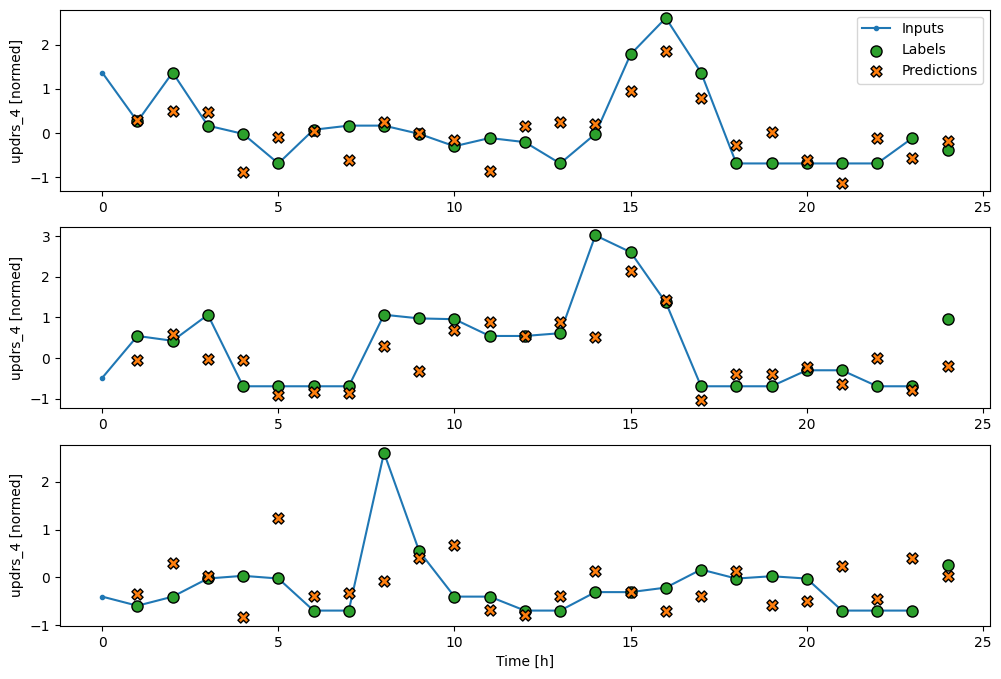

In [ ]:
wide_window.plot(linear)

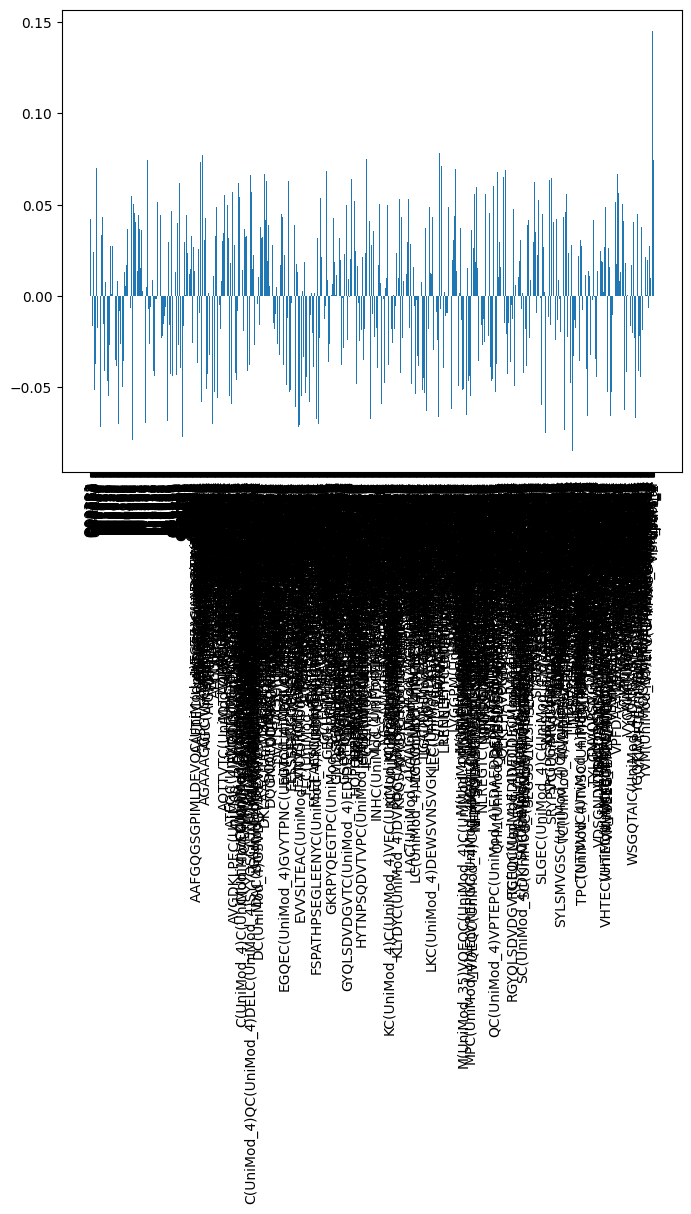

In [ ]:
# plt.bar(x = range(len(train_df.columns)),
#         height=linear.layers[0].kernel[:,0].numpy())
# axis = plt.gca()
# axis.set_xticks(range(len(train_df.columns)))
# _ = axis.set_xticklabels(train_df.columns, rotation=90)

In [ ]:
dense = tf.keras.Sequential([
    tf.keras.layers.Dense(units=64, activation='relu'),
    tf.keras.layers.Dense(units=64, activation='relu'),
    tf.keras.layers.Dense(units=1)
])

history = compile_and_fit(dense, single_step_window)

val_performance['Dense'] = dense.evaluate(single_step_window.val)
performance['Dense'] = dense.evaluate(single_step_window.test, verbose=0)

Epoch 1/20
25/25 [==============================] - 4s 32ms/step - loss: 1.7441 - mean_absolute_error: 0.9592 - val_loss: 1.0775 - val_mean_absolute_error: 0.7506
Epoch 2/20
25/25 [==============================] - 1s 18ms/step - loss: 0.8520 - mean_absolute_error: 0.6536 - val_loss: 0.9295 - val_mean_absolute_error: 0.7014
Epoch 3/20
25/25 [==============================] - 0s 9ms/step - loss: 0.4758 - mean_absolute_error: 0.4767 - val_loss: 0.8969 - val_mean_absolute_error: 0.6848
Epoch 4/20
25/25 [==============================] - 0s 10ms/step - loss: 0.3194 - mean_absolute_error: 0.4063 - val_loss: 0.9031 - val_mean_absolute_error: 0.6979
Epoch 5/20
7/7 [==============================] - 0s 4ms/step - loss: 0.9917 - mean_absolute_error: 0.7513


In [ ]:
## Convolutional model

In [ ]:
conv_model = tf.keras.Sequential([
    tf.keras.layers.Conv1D(filters=32,
                           kernel_size=(CONV_WIDTH,),
                           activation='relu'),
    tf.keras.layers.Dense(units=32, activation='relu'),
    tf.keras.layers.Dense(units=1),
])

In [ ]:
print("Conv model on `conv_window`")
print('Input shape:', conv_window.example[0].shape)
print('Output shape:', conv_model(conv_window.example[0]).shape)

Conv model on `conv_window`
Input shape: (32, 3, 1203)
Output shape: (32, 1, 1)


In [ ]:
history = compile_and_fit(conv_model, conv_window)

IPython.display.clear_output()
val_performance['Conv'] = conv_model.evaluate(conv_window.val)
performance['Conv'] = conv_model.evaluate(conv_window.test, verbose=0)

7/7 [==============================] - 0s 6ms/step - loss: 1.2996 - mean_absolute_error: 0.8695


In [ ]:
LABEL_WIDTH = 24
INPUT_WIDTH = LABEL_WIDTH + (CONV_WIDTH - 1)
wide_conv_window = WindowGenerator(
    input_width=INPUT_WIDTH,
    label_width=LABEL_WIDTH,
    shift=1,
    label_columns=['updrs_4'])

wide_conv_window

Total window size: 27
Input indices: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25]
Label indices: [ 3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26]
Label column name(s): ['updrs_4']

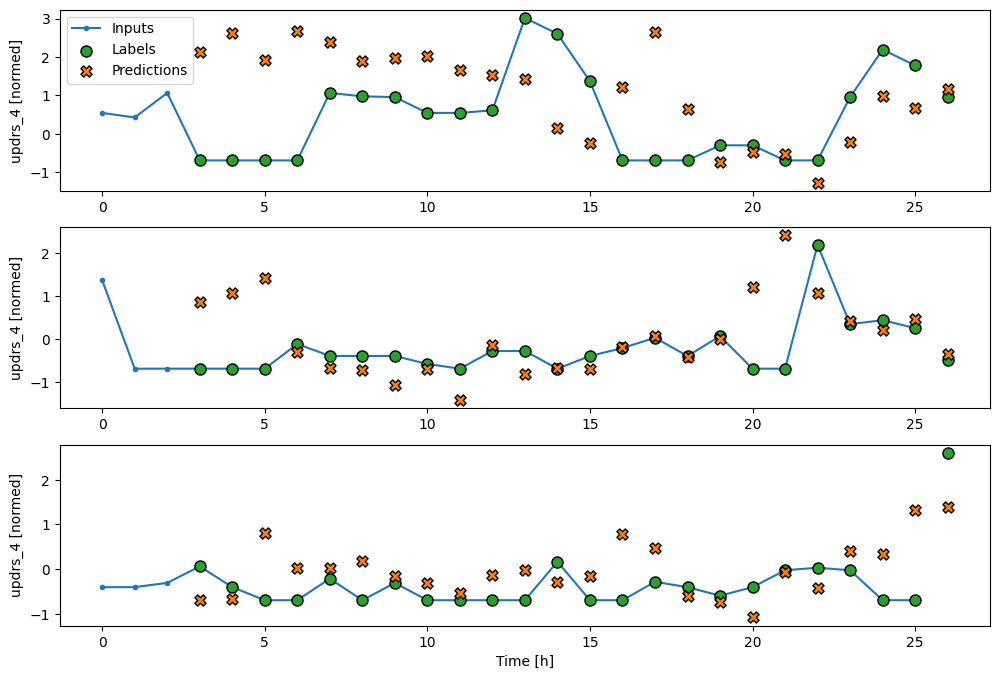

In [ ]:
wide_conv_window.plot(conv_model)

In [ ]:
## LSTM
lstm_model = tf.keras.models.Sequential([
    # Shape [batch, time, features] => [batch, time, lstm_units]
    tf.keras.layers.LSTM(32, return_sequences=True),
    # Shape => [batch, time, features]
    tf.keras.layers.Dense(units=1)
])

In [ ]:
history = compile_and_fit(lstm_model, wide_window)

IPython.display.clear_output()
val_performance['LSTM'] = lstm_model.evaluate(wide_window.val)
performance['LSTM'] = lstm_model.evaluate(wide_window.test, verbose=0)

7/7 [==============================] - 0s 21ms/step - loss: 0.9574 - mean_absolute_error: 0.7004


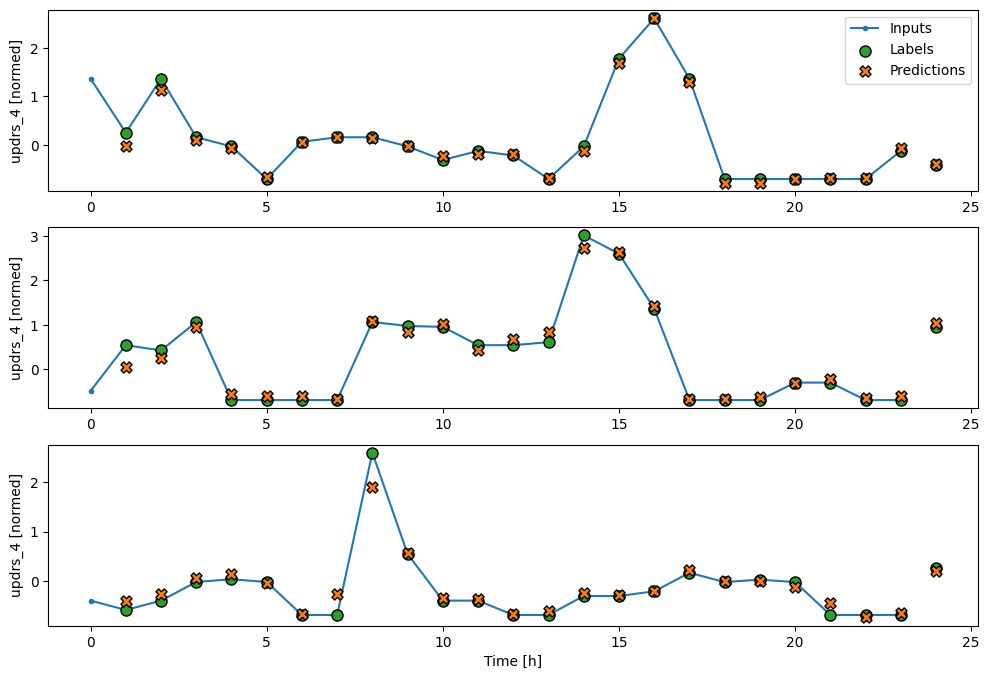

In [ ]:
wide_window.plot(lstm_model)

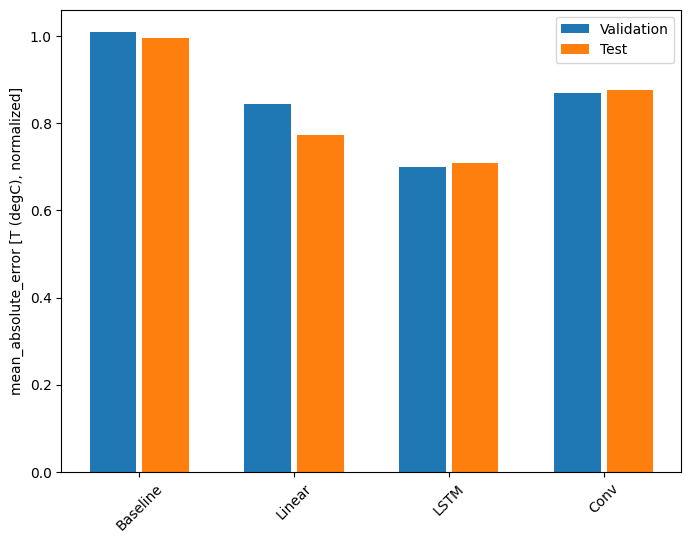

In [ ]:
x = np.arange(len(performance))
width = 0.3
metric_name = 'mean_absolute_error'
metric_index = lstm_model.metrics_names.index('mean_absolute_error')
val_mae = [v[metric_index] for v in val_performance.values()]
test_mae = [v[metric_index] for v in performance.values()]

plt.ylabel('mean_absolute_error [T (degC), normalized]')
plt.bar(x - 0.17, val_mae, width, label='Validation')
plt.bar(x + 0.17, test_mae, width, label='Test')
plt.xticks(ticks=x, labels=performance.keys(),
           rotation=45)
_ = plt.legend()

7/7 [==============================] - 0s 5ms/step - loss: 1.3291 - mean_absolute_error: 0.8858


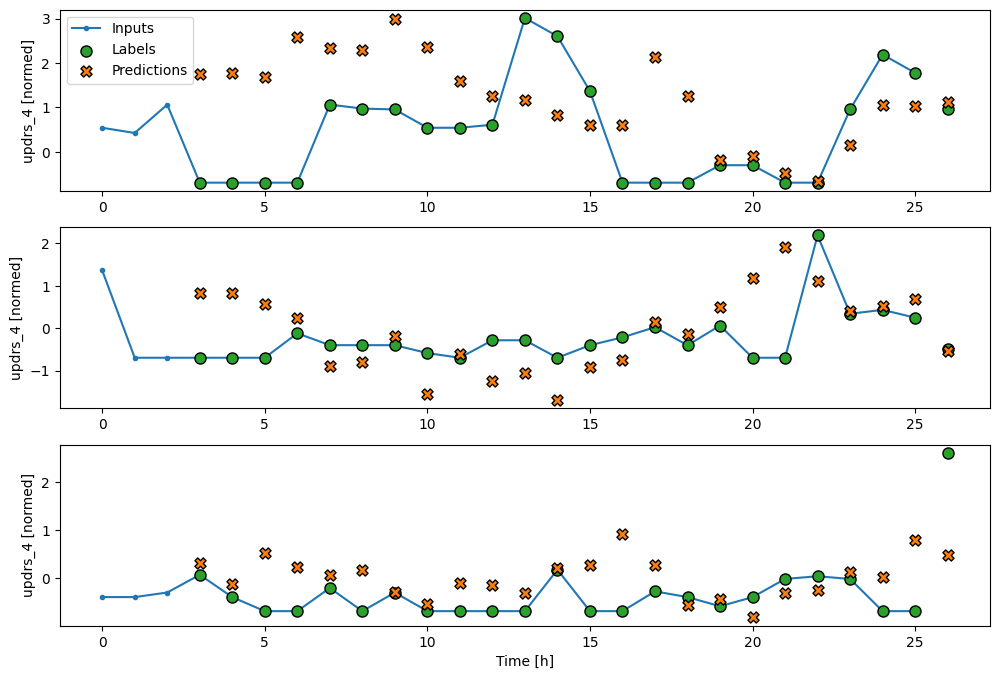

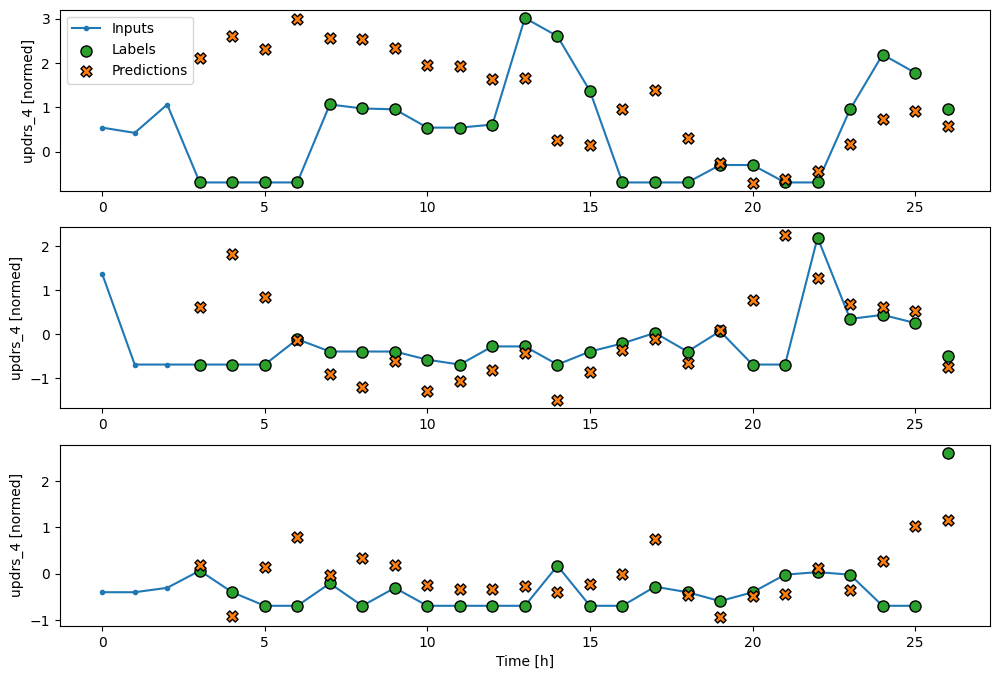

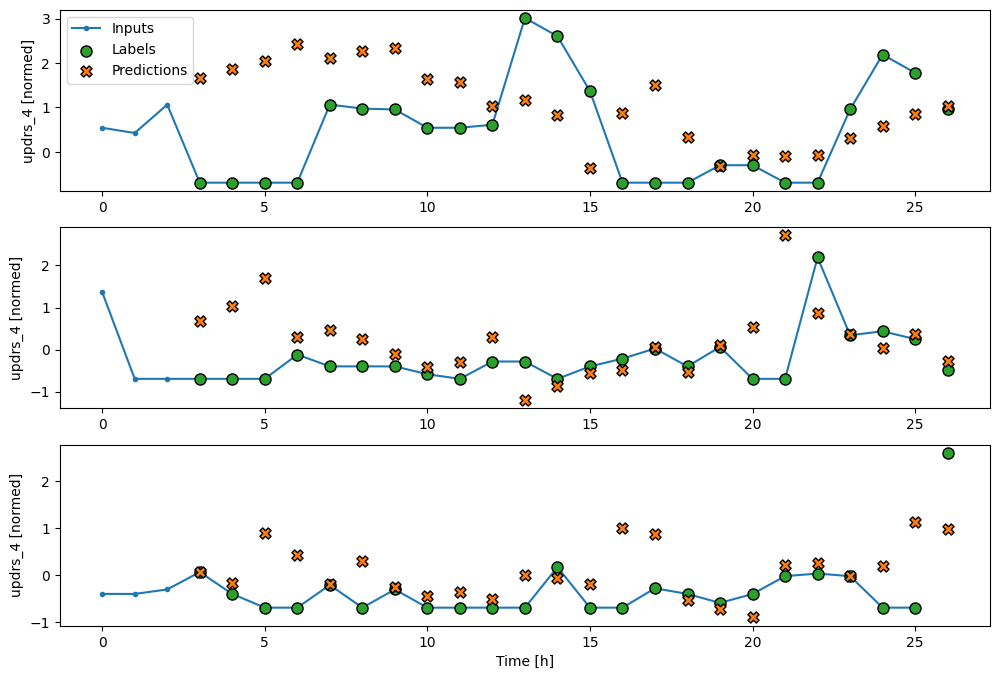

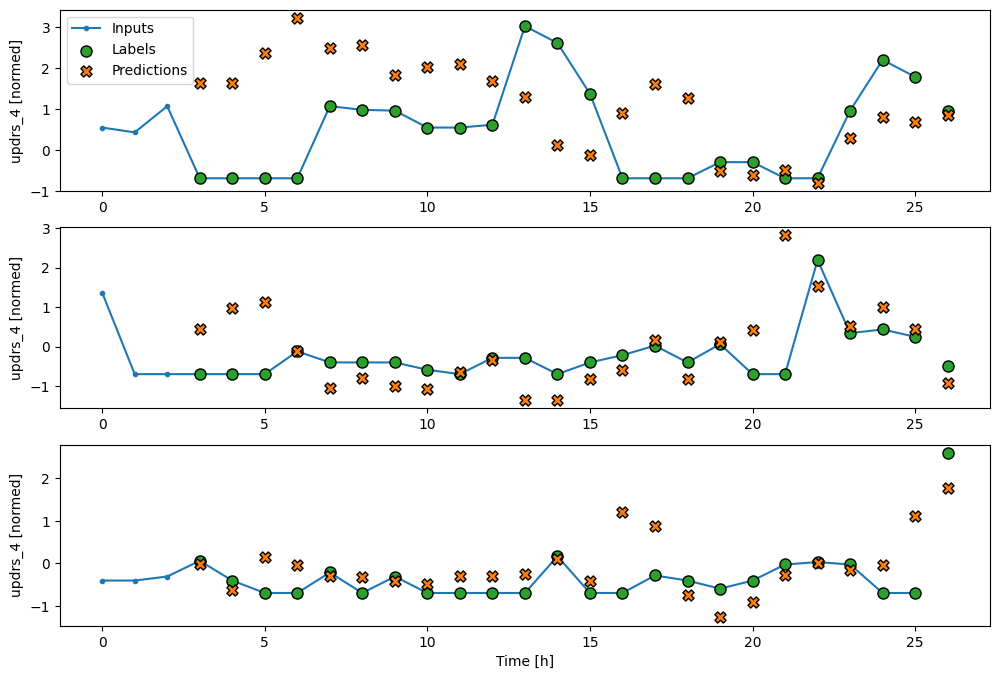

In [ ]:
# List of target labels to loop through and train models
target = ["updrs_1", "updrs_2", "updrs_3", "updrs_4"]

# Loop through each label
for label in target:

    # Make a new copy of the FEATURES list we created previously. Add `label` to it.
    feature_list = FEATURES.copy()
    feature_list.append(label)

    # Split the dataset into train and validation datasets.
    train_df, val_df, test_df = split_dataset(dataset_df[feature_list])
    train_df, val_df, test_df = normalize_datset(train_df, val_df, test_df)

    ## create the neural network model CNN
    conv_model = tf.keras.Sequential([
    tf.keras.layers.Conv1D(filters=32,
                           kernel_size=(CONV_WIDTH,),
                           activation='relu'),
    tf.keras.layers.Dense(units=32, activation='relu'),
    tf.keras.layers.Dense(units=1),
])
    history = compile_and_fit(conv_model, conv_window)

    IPython.display.clear_output()
    val_performance['Conv'] = conv_model.evaluate(conv_window.val)
    performance['Conv'] = conv_model.evaluate(conv_window.test, verbose=0)
    wide_conv_window.plot(conv_model)


,O00391,O00533,O00584,O14498,O14773,O14791,O15240,O15394,O43505,O60888,...,YYTYLIMNK,YYWGGQYTWDMAK,patient_id,visit_month,updrs_1,updrs_2,updrs_3,updrs_4,visit_month,updrs_4
0,-0.937961,-0.494900,-1.078117,-0.073171,-1.498616,-0.388367,-0.591076,-1.688796,-0.366147,-0.322538,...,-0.526915,-1.315989,-1.324237,-1.208017,-0.665276,-0.973506,-0.274393,-0.694672,-1.208017,-0.694672
1,-0.392921,-0.356370,-1.168273,0.095091,-0.354947,0.768719,0.976894,-1.689494,-0.405142,-0.680330,...,0.171032,0.516346,-1.324237,-0.656888,-0.475906,-0.630432,-0.620621,-0.694672,-0.656888,-0.694672
2,0.717856,-0.057365,-1.774802,-0.320862,-0.270290,-0.503004,0.006673,-1.632232,-0.356204,0.271014,...,0.400902,0.102164,-1.324237,-0.381324,-0.854646,-0.630432,-1.174585,-0.694672,-0.381324,-0.694672
3,0.463157,-0.110690,-1.586384,-0.003449,0.798202,2.834676,0.416232,0.207888,0.101507,-1.558641,...,1.382518,-1.046107,-1.317606,-0.656888,-0.665276,0.055718,0.972027,-0.694672,-0.656888,-0.694672
4,0.223888,0.004069,-2.017796,-1.193683,1.786345,-0.235088,0.345551,0.101670,0.571622,-1.062270,...,0.740359,-1.548925,-1.317606,-0.105760,-0.475906,0.227255,0.141080,3.428787,-0.105760,3.428787
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
774,-0.156422,0.095223,0.457160,0.142372,0.453085,0.883055,0.562003,0.006593,0.047815,-0.082745,...,-0.233556,1.272612,1.924945,0.445368,0.092204,-0.458894,0.279572,0.542366,0.445368,0.542366
775,-0.094492,-0.672554,-0.008232,-0.065331,-0.260317,0.555855,-0.532572,-0.345767,-1.250464,-0.506869,...,-0.525244,1.213919,1.924945,0.996497,-0.286536,-0.458894,0.210326,-0.694672,0.996497,-0.694672
776,0.120451,-0.018015,0.449644,-0.389597,0.229754,0.347524,0.303698,-0.031598,0.122451,-0.650984,...,1.499695,1.932781,1.924945,2.098754,-0.097166,-0.115819,0.348817,-0.694672,2.098754,-0.694672
777,-0.223188,0.662505,0.224201,0.210630,0.572641,-0.622121,0.557181,0.109549,0.262253,-0.840611,...,1.077070,0.408694,-1.704497,-1.208017,0.470944,-0.801969,-0.966849,0.218542,-1.208017,0.218542
